In [1]:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

import sys
sys.path.append('/home/chris/repos/sentiment_analysis/')

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from credential import * 

def twitter_setup():
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

extractor = twitter_setup()

In [3]:
account = 'realDonaldTrump'

tweets = extractor.user_timeline(screen_name=account, count=1000)
# We print the most recent 5 tweets:
print("5 recent tweets: of "+account)
for tweet in tweets[:5]:
    print(tweet.text)
    print()

5 recent tweets: of realDonaldTrump
If the E.U. wants to further increase their already massive tariffs and barriers on U.S. companies doing business t… https://t.co/taytTlApWc

The United States has an $800 Billion Dollar Yearly Trade Deficit because of our “very stupid” trade deals and poli… https://t.co/nFF3vEmRmY

Mainstream Media in U.S. is being mocked all over the world. They’ve gone CRAZY! https://t.co/4UGYuJpUA7

Happy National Anthem Day! https://t.co/cf1eugMbKU

REST IN PEACE BILLY GRAHAM! https://t.co/2qMoUccVC2



In [4]:

user = extractor.get_user(account)
followers = str(user.followers_count)
print('The account of ' + account + ' has ' + followers +' followers')

The account of realDonaldTrump has 48529105 followers


In [5]:
# We create a pandas dataframe as follows:
data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

# We display the first 10 elements of the dataframe:
display(data.head(2))

,Tweets
0,If the E.U. wants to further increase their al...
1,The United States has an $800 Billion Dollar Y...


In [6]:
# We print info from the first tweet:
print(tweets[0].id)
print(tweets[0].created_at)
print(tweets[0].source)
print(tweets[0].favorite_count)
print(tweets[0].retweet_count)
print(tweets[0].geo)
print(tweets[0].coordinates)
print(tweets[0].entities)


969994273121820672
2018-03-03 17:53:50
Twitter for iPhone
85281
22155
None
None
{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/taytTlApWc', 'expanded_url': 'https://twitter.com/i/web/status/969994273121820672', 'display_url': 'twitter.com/i/web/status/9…', 'indices': [117, 140]}]}


In [7]:
# We add relevant data:
data['len']  = np.array([len(tweet.text) for tweet in tweets])
data['ID']   = np.array([tweet.id for tweet in tweets])
data['Date'] = np.array([tweet.created_at for tweet in tweets])
data['Source'] = np.array([tweet.source for tweet in tweets])
data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

In [8]:
# We extract the mean of lenghts:
mean = np.mean(data['len'])

print("The lenght's average in tweets: {}".format(mean))

The lenght's average in tweets: 127.115


In [9]:
# We extract the tweet with more FAVs and more RTs:
fav_max = np.max(data['Likes'])
rt_max  = np.max(data['RTs'])

fav = data[data.Likes == fav_max].index[0]
rt  = data[data.RTs == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data['Tweets'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data['Tweets'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data['len'][rt]))

The tweet with more likes is: 
Somebody please inform Jay-Z that because of my policies, Black Unemployment has just been reported to be at the LOWEST RATE EVER RECORDED!
Number of likes: 239899
139 characters.

The tweet with more retweets is: 
Somebody please inform Jay-Z that because of my policies, Black Unemployment has just been reported to be at the LOWEST RATE EVER RECORDED!
Number of retweets: 63766
139 characters.



In [10]:
tlen = pd.Series(data=data['len'].values, index=data['Date'])
tfav = pd.Series(data=data['Likes'].values, index=data['Date'])
tret = pd.Series(data=data['RTs'].values, index=data['Date'])

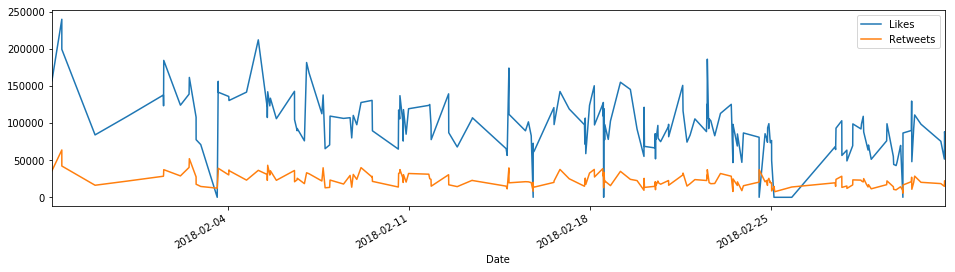

In [11]:
#tlen.plot(figsize=(16,4),label="Length", color='r');
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True)

In [12]:
import scipy

corr_coeff = scipy.stats.pearsonr(tfav, tret)
print('Der Korrelationskoeffizient zwischen Likes und Retweets ist:')
print('------------------------------------------------------------')
print(corr_coeff[0])

Der Korrelationskoeffizient zwischen Likes und Retweets ist:
------------------------------------------------------------
0.833131487883


In [13]:
sources = []
for source in data['Source']:
    if source not in sources:
        sources.append(source)

print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter for iPhone
* Media Studio
* Twitter for iPad


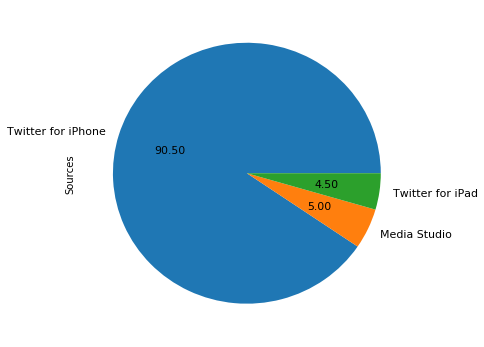

In [14]:
# We create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', figsize=(6, 6));

In [15]:
from textblob import TextBlob

import re

def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [16]:
# We create a column with the result of the analysis:
data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])

In [17]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

### Sentiment results for given account

In [18]:
# We print percentages:

print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data['Tweets'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data['Tweets'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(data['Tweets'])))

Percentage of positive tweets: 51.0%
Percentage of neutral tweets: 28.0%
Percentage de negative tweets: 21.0%


### Create a Wordcloud

In [19]:
from collections import Counter

words = set()
word_counts = data['Tweets'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
#word_counts.Tweets.astype(str)

In [20]:
test = word_counts.to_frame()

In [21]:
'''word_counts = word_counts.fillna('x')
d = {}
for a, x in word_counts.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()'''

'word_counts = word_counts.fillna(\'x\')\nd = {}\nfor a, x in word_counts.values:\n    d[a] = x\n\nimport matplotlib.pyplot as plt\nfrom wordcloud import WordCloud\n\nwordcloud = WordCloud()\nwordcloud.generate_from_frequencies(frequencies=d)\nplt.figure()\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()'

## Analize tweets associated with certain hashtags

In [22]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import re

def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment_tweet(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [39]:
MAX_TWEETS = 200
tweet_spd = []
for tweet in tweepy.Cursor(extractor.search, q='#weidelkickingthings', rpp=100).items(MAX_TWEETS):
    tweet_spd.append(tweet.text)
    pass


In [40]:
data_spd = pd.DataFrame()
data_spd['tweets'] = np.array(tweet_spd)
#data_spd['SA'] = np.array([ analize_sentiment(tweet) for tweet in data_spd['tweets_spd'] ])
data_spd.head(n=3)

,tweets
0,RT @Ruebenhorst: #WeidelKickingThings https://...
1,"Jeder Preißenbeidl, der #Nermberch S O wie unt..."
2,"RT @DrOetkerPizzaDE: Ok, manche unserer Pizzen..."


### Now calculate the sentiment score for the collected tweets 

In [41]:
data_spd['SA'] = np.array([ analize_sentiment_tweet(tweet) for tweet in data_spd['tweets'] ])

In [42]:
# We print percentages:

print("Percentage of positive tweets: {}%".format(data_spd.query('SA>1').shape[0]*100/len(data_spd['tweets'])))
print("Percentage of neutral tweets: {}%".format(data_spd.query('SA==1').shape[0]*100/len(data_spd['tweets'])))
print("Percentage of negative tweets: {}%".format(data_spd.query('SA<1').shape[0]*100/len(data_spd['tweets'])))

Percentage of positive tweets: 0.0%
Percentage of neutral tweets: 14.0%
Percentage of negative tweets: 86.0%
